In [19]:
import numpy as np
from scipy.io import wavfile
from matplotlib import pyplot as plt
import time

In [20]:
#file = "string_1.wav"
file = "truck.wav"
sample_rate, signal = wavfile.read(file)
#since the signal is stereo, we will only use one channel
signal = signal[:, 0]
print(sample_rate)

48000


In [21]:
attenuation = 0.5
#compute the amount of frames in the signal to delay afte
seconds_to_delay = 0.3
frame_delay = int(seconds_to_delay * sample_rate)

In [22]:
def delay_filter(signal, attenuation, time_delay):
    """
    The function for the delay filter:
    output[t] = signal[t] + attenuation * signal[t-time_delay]
    For the first time_delay frames, we pad the signal with zeros
    """
    #left-zero-pad the signal by time_delay-1
    padded_signal = np.pad(signal, (time_delay-1, 0), 'constant', constant_values=(0, 0))
    #remove frames unnecessary for the delay and now will match dimensions
    padded_signal = padded_signal[:-time_delay+1]
    #add the delayed signal to the original signal
    new_signal = signal + attenuation * padded_signal
    return new_signal

We can compute the impulse response by applying the FIR filter to the dirac vector.

In [23]:
dirac = np.zeros(frame_delay)
dirac[0] = 1

impulse_response = delay_filter(dirac, attenuation, frame_delay)

Text(0, 0.5, 'Amplitude')

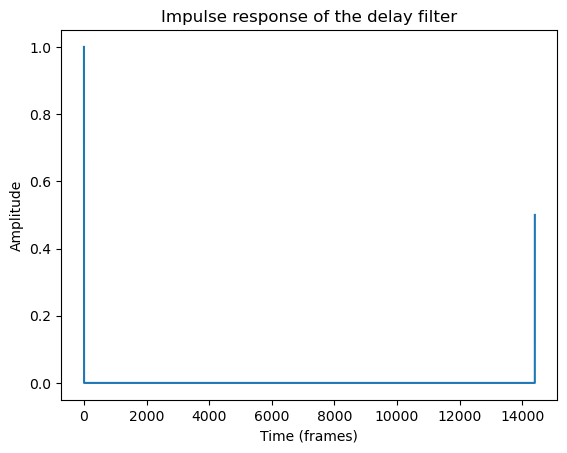

In [24]:
plt.plot(impulse_response, label="dirac")
plt.title("Impulse response of the delay filter")
plt.xlabel("Time (frames)")
plt.ylabel("Amplitude")

We can use the computed impulse response to apply the filter to any signal by convolving the two.

In [25]:
def fir(signal, impulse_response):
    """
    Given a signal, convolve it with the impulse response.
    """
    signal_padded = np.pad(signal, (len(impulse_response)-1, 0), 'constant', constant_values=(0, 0))
    new_signal = np.convolve(signal_padded, impulse_response, mode='valid')
    return new_signal

In [26]:
#time to filter the signal
start = time.time()
delay_filter_signal = delay_filter(signal, attenuation, frame_delay)
end = time.time()
print("Delay filter took {0:.5f} seconds".format(end-start))
start = time.time()
filtered_signal_fir = fir(signal, impulse_response)
end = time.time()
print("Computing the FIR delay by convolving the impulse response and signal took {0:.5f} seconds".format(end-start))

Delay filter took 0.00459 seconds
Computing the FIR delay by convolving the impulse response and signal took 4.20082 seconds


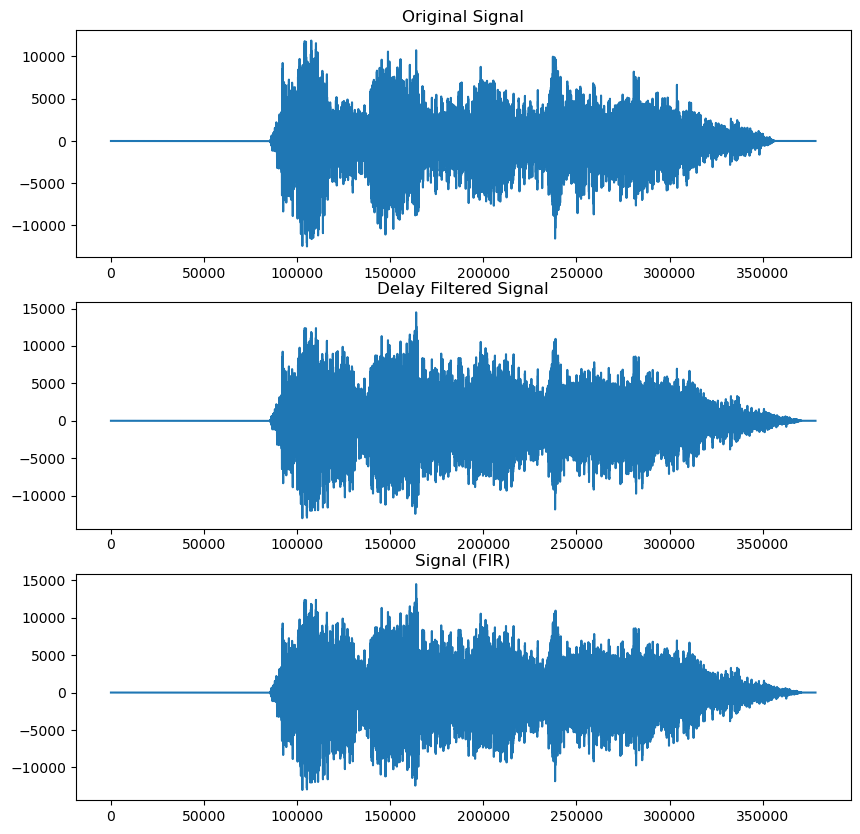

In [27]:
#plot the original signal, the delay filter signal, and the signal after applying the FIR
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].plot(signal)
axs[0].set_title('Original Signal')
axs[1].plot(delay_filter_signal)
axs[1].set_title('Delay Filtered Signal')
axs[2].plot(filtered_signal_fir)
axs[2].set_title('Signal (FIR)')
plt.show()

We can see that both the filter function and the FIR convolution result in the same output signal.

In [28]:
#compute distance between the two signals
distance = np.linalg.norm(delay_filter_signal-filtered_signal_fir)
print(distance)

0.0


In [29]:
#play the signal
from IPython.display import Audio
Audio(signal, rate=sample_rate)

In [30]:
Audio(filtered_signal_fir, rate=sample_rate)

The FIR causes an echo effect in the signal.

Additionally, the convolution operation is much slower than the filter function.